In [289]:
# code to create boxplots
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# All trends

### Data import


it is warming everywhere -> but magnitude changes
-> influence of clear sky pixels ? verify with ERA5 land and satellite cloud cover !

In [290]:
trends_noaa_all = xr.open_dataset('significant_trends_1981_2007.nc')

In [291]:
trends_noaa_all

<xarray.Dataset>
Dimensions:                        (lat: 340, lon: 360)
Coordinates:
  * lat                            (lat) float32 55.03 55.08 ... 71.93 71.97
  * lon                            (lon) float32 -168.0 -167.9 ... -150.1 -150.0
Data variables:
    __xarray_dataarray_variable__  (lat, lon) float64 ...

In [292]:
trends_noaa_all['trends'] = trends_noaa_all['__xarray_dataarray_variable__'] *10

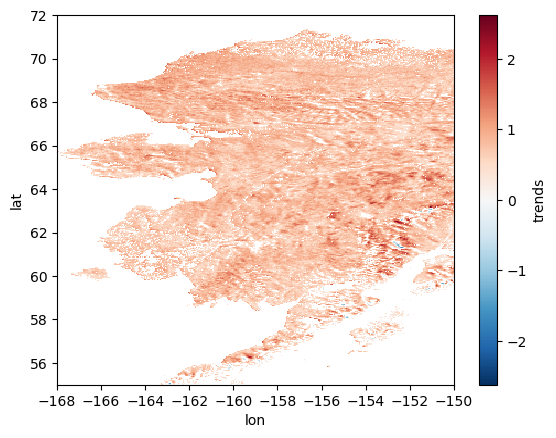

In [293]:
trends_noaa_all['trends'].plot();

In [294]:
wetness = xr.open_dataset('../alaska_wt_gradients.nc')

In [295]:
wetness

<xarray.Dataset>
Dimensions:      (x: 3281, y: 1955, band: 1)
Coordinates:
  * x            (x) float64 -171.3 -171.3 -171.3 ... -142.0 -142.0 -142.0
  * y            (y) float64 72.79 72.78 72.77 72.76 ... 55.35 55.34 55.33 55.33
  * band         (band) int64 1
Data variables:
    spatial_ref  int64 ...
    band_data    (band, y, x) float32 ...

In [296]:
# load landcover and anette's landcover! (first normal landcover)
land_cover = xr.open_dataset('/mnt/data7/nfs4/avh_ndvi/sdupuis/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7b.nc', engine='netcdf4')

In [297]:
lc = land_cover.sel(lat=slice(72,55), lon=slice(-168,-150))

In [298]:
lc_interp = lc.interp(lat=trends_noaa_all.coords['lat'], lon=trends_noaa_all.coords['lon'], method='nearest')

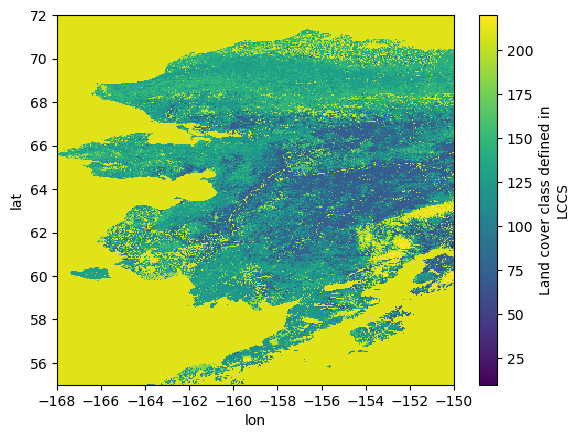

In [299]:
lc_interp['lccs_class'].plot();

In [300]:
wetness_interp = wetness['band_data'].interp(y=trends_noaa_all.coords['lat'], x=trends_noaa_all.coords['lon'], method='nearest').squeeze()

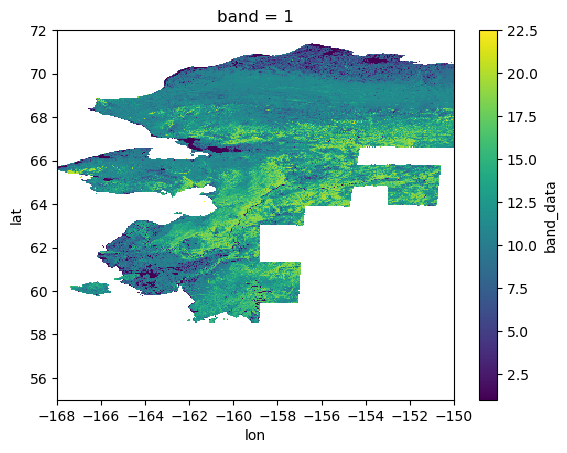

In [301]:
wetness_interp.plot();

In [302]:
trend_w = trends_noaa_all.where(~np.isnan(wetness_interp))
wet = wetness_interp.where(~np.isnan(trends_noaa_all['__xarray_dataarray_variable__'])).squeeze()

In [303]:
trend = trends_noaa_all.where(~np.isnan(lc_interp['lccs_class']))
landcover = lc_interp.where(~np.isnan(trends_noaa_all['__xarray_dataarray_variable__']))

In [304]:
landcover

<xarray.Dataset>
Dimensions:              (lat: 340, lon: 360)
Coordinates:
  * lat                  (lat) float32 55.03 55.08 55.12 ... 71.88 71.93 71.97
  * lon                  (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.0
Data variables:
    lccs_class           (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    processed_flag       (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    current_pixel_state  (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    observation_count    (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    change_count         (lat, lon) float32 nan nan nan nan ... nan nan nan nan
    crs                  (lat, lon) float64 nan nan nan nan ... nan nan nan nan
Attributes: (12/38)
    title:                      ESA CCI Land Cover Map
    summary:                    This dataset contains the global ESA CCI land...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180.0
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

In [345]:
trend_1d = trend['trends'].stack(points=("lat", "lon"))
lc_1d = landcover['lccs_class'].stack(points=("lat", "lon"))

In [346]:
trend_1d_w = trend_w['trends'].stack(points=("lat", "lon"))
lc_1d_w = wet.stack(points=("lat", "lon"))

In [347]:
valid = (~np.isnan(trend_1d_w)) & (~np.isnan(lc_1d_w))
trend_1d_w = trend_1d_w[valid]
lc_1d_w = lc_1d_w[valid]

In [348]:
valid = (~np.isnan(trend_1d)) & (~np.isnan(lc_1d))
trend_1d = trend_1d[valid]
lc_1d = lc_1d[valid]

In [377]:
df_2 = pd.DataFrame({
    "trend": trend_1d_w.values,
    "landcover": lc_1d_w.values.astype(int)
})

In [378]:
# filter classes with very low samples
counts = df_2["landcover"].value_counts()
valid_classes = counts[counts > 10].index

df_2 = df_2[df_2["landcover"].isin(valid_classes)]

In [379]:
counts

landcover
10    8282
11    7914
9     3916
12    3837
13    3337
14    2965
15    2574
8     2272
16    2188
17    1904
18    1558
7     1429
6      801
19     659
5      429
4      249
3      141
2       45
20      36
1       30
21       5
Name: count, dtype: int64

In [367]:
df = pd.DataFrame({
    "trend": trend_1d.values,
    "landcover": lc_1d.values.astype(int)
})


In [ ]:
lc_wetness_map = {
    # 1. Agriculture
    1: "water",
    2: "Cropland",
    3: "Cropland",
    4: "Cropland",

    # 2. Forest
    50: "BEV",
    60: "BD", 61: "BD", 62: "BD",
    70: "NEV", 71: "NEV", 72: "NEV",
    80: "ND", 81: "ND", 82: "ND",
    90: "Mixed Forest",
    100: "Mixed Forest",
    160: "Flooded forest",
    170: "Flooded forest",

    # 3. Grassland
    110: "Grassland",
    130: "Grassland",

    # 4. Wetland
    180: "Wetland",

    # 5. Settlement
    190: "Settlement",

    # 6. Other (Shrubland / Sparse / Bare / Water)
    120: "Shrubland",
    121: "Shrubland",
    122: "Shrubland",
    140: "Lichens",
    150: "Sparse",
    151: "Sparse",
    152: "Sparse",
    153: "Sparse",
    200: "Bare",
    201: "Bare",
    202: "Bare",
    220: "Ice"
}

In [368]:
lc_group_map = {
    # 1. Agriculture
    10: "Cropland",
    20: "Cropland",
    30: "Cropland",
    40: "Cropland",

    # 2. Forest
    50: "BEV",
    60: "BD", 61: "BD", 62: "BD",
    70: "NEV", 71: "NEV", 72: "NEV",
    80: "ND", 81: "ND", 82: "ND",
    90: "Mixed Forest",
    100: "Mixed Forest",
    160: "Flooded forest",
    170: "Flooded forest",

    # 3. Grassland
    110: "Grassland",
    130: "Grassland",

    # 4. Wetland
    180: "Wetland",

    # 5. Settlement
    190: "Settlement",

    # 6. Other (Shrubland / Sparse / Bare / Water)
    120: "Shrubland",
    121: "Shrubland",
    122: "Shrubland",
    140: "Lichens",
    150: "Sparse",
    151: "Sparse",
    152: "Sparse",
    153: "Sparse",
    200: "Bare",
    201: "Bare",
    202: "Bare",
    220: "Ice"
}


In [369]:
df["landcover_group"] = df["landcover"].map(lc_group_map)

In [370]:
df

,trend,landcover,landcover_group
0,0.619089,120,Shrubland
1,0.660900,120,Shrubland
2,-0.484706,200,Bare
3,0.322026,120,Shrubland
4,0.368594,120,Shrubland
...,...,...,...
62045,0.741107,140,Lichens
62046,0.543709,140,Lichens
62047,0.408276,140,Lichens
62048,0.735362,140,Lichens


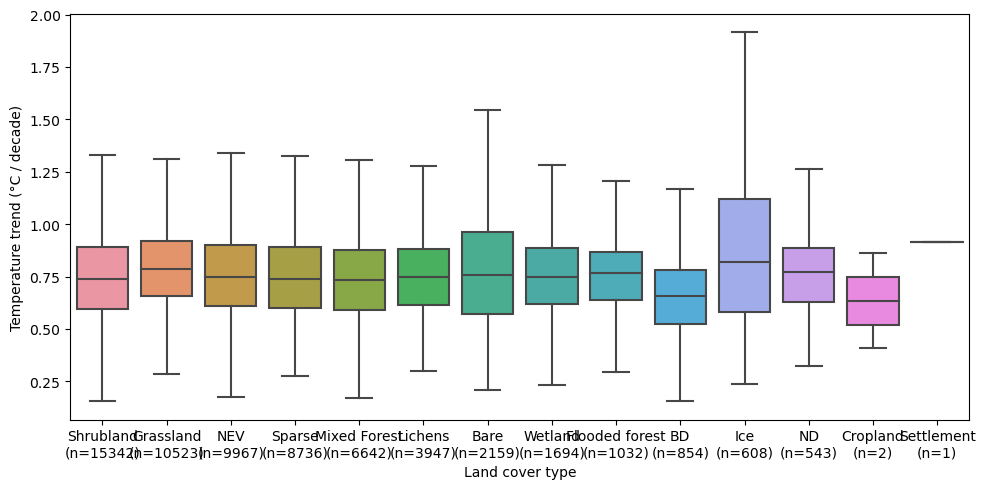

In [371]:
# Count samples per class
counts = df["landcover_group"].value_counts()

# Order classes by appearance or median
order = counts.index

plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=df,
    x="landcover_group",
    y="trend",
    order=order,
    showfliers=False
)

# Update x-tick labels to include counts
new_labels = [
    f"{label}\n(n={counts[label]})"
    for label in order
]

ax.set_xticklabels(new_labels)

ax.set_xlabel("Land cover type")
ax.set_ylabel("Temperature trend (°C / decade)")
plt.tight_layout()
plt.show()


In [372]:
# filter classes with very low samples
counts = df["landcover_group"].value_counts()
valid_classes = counts[counts > 20].index

df = df[df["landcover_group"].isin(valid_classes)]


In [373]:
counts

landcover_group
Shrubland         15342
Grassland         10523
NEV                9967
Sparse             8736
Mixed Forest       6642
Lichens            3947
Bare               2159
Wetland            1694
Flooded forest     1032
BD                  854
Ice                 608
ND                  543
Cropland              2
Settlement            1
Name: count, dtype: int64

### results all noaa

In [374]:
df

,trend,landcover,landcover_group
0,0.619089,120,Shrubland
1,0.660900,120,Shrubland
2,-0.484706,200,Bare
3,0.322026,120,Shrubland
4,0.368594,120,Shrubland
...,...,...,...
62045,0.741107,140,Lichens
62046,0.543709,140,Lichens
62047,0.408276,140,Lichens
62048,0.735362,140,Lichens


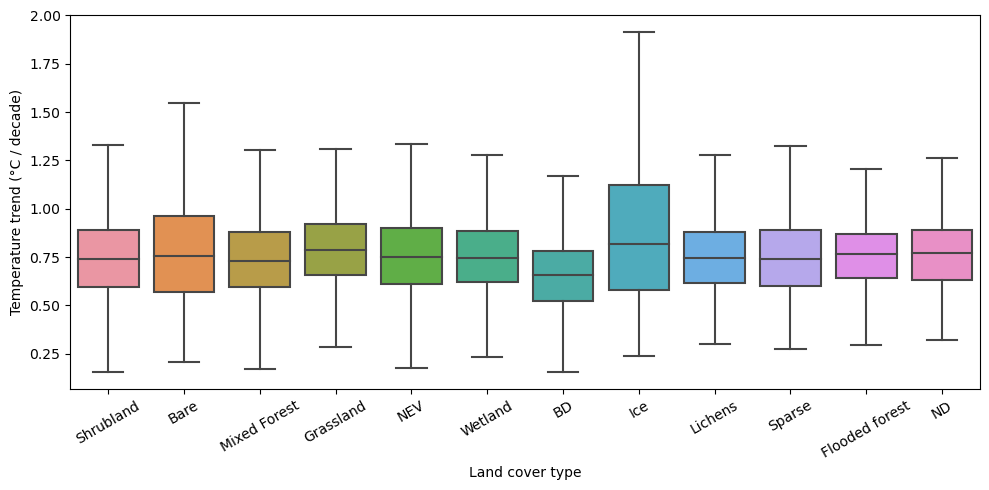

In [375]:
# merge the classes ! 

plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df,
    x="landcover_group",   # or "landcover"
    y="trend",
    showfliers=False
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("Land cover type")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 220: permanent snow and ice, 200: bare areas, 180: shrub or herbaceous cover, 160: tree cover, flooded, fresh or brackish water, 152: sparse vegetation, 150:sparse vegetation,
# 140 : liches and moss, 130, grasssland, 120: shrubland, 100: mosaic tree nad shrubs, 90: tree cover, mixed leaves, 80, tree cover decidious, needlleaved, 70, needleaved, evegergren,
# 61 : borad leave deciduous

In [376]:
df_2

,trend,landcover
0,0.835443,9
1,0.955506,14
2,0.801138,15
3,0.468060,15
4,0.988522,7
...,...,...
44566,0.741107,7
44567,0.543709,7
44568,0.408276,4
44569,0.735362,7


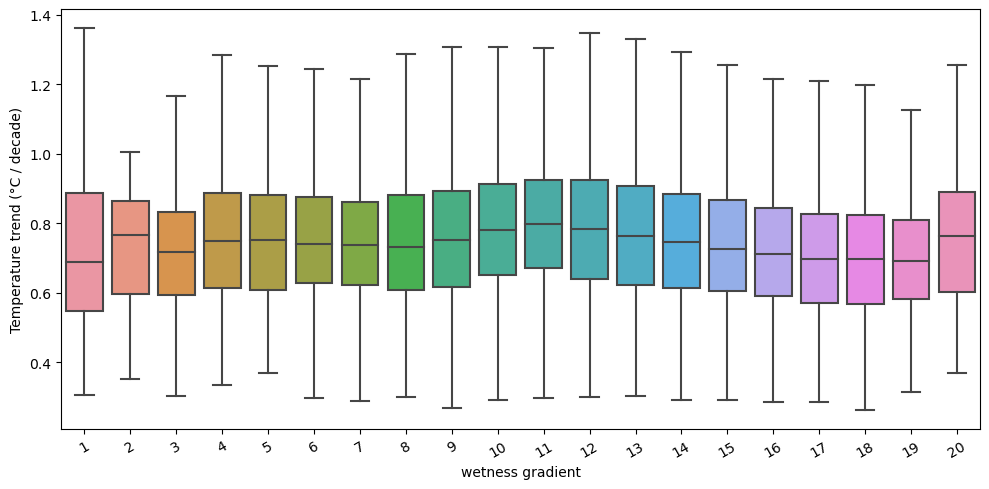

In [317]:
# verify legends
plt.figure(figsize=(10, 5))
sns.boxplot(
    data=df_2,
    x="landcover",   # or "landcover"
    y="trend",
    showfliers=False
)

plt.ylabel("Temperature trend (°C / decade)")
plt.xlabel("wetness gradient")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# check box plots from Sina -> verify with air temperature !!! -> check "AWI stations"
# 3 wetland, permanent, 4 wet wet to aquatic tundra (seasonal), abundant moss, 5 Moist to wet tundra, abundant moss, prostrate shrubs, 6 dry to moist tundra, partially barren, prostrate shrubs
# 7 dry tundra, abundant lichen, prostrate shrubs, 8 dry to aquatic tundra, dwarf shrubs (& sparse tree cover along treeline), 9 dry to moist tundra, prostrate to low shrubs
# 10 moist tundra, abundant moss, prostrate to low shrubs, 11 moist tundra, abundant moss, dwarf and low shrubs
# different grouping !

In [318]:
# cluster with reference to air temperature or differences to air temperature ??? 

In [319]:
# recompute trends for snow cover onset -> or mean values ? yes mean values !
# satellite product ? do like for emissivity ? trends of snow cover ??? -> something more simple ! -> trends need to be recomputed!

arclim = xr.open_dataset('../arclim_means.nc')

In [320]:
arclim

<xarray.Dataset>
Dimensions:    (longitude: 3600, latitude: 451)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... 45.3 45.2 45.1 45.0
Data variables: (12/18)
    GSL        (latitude, longitude) float64 ...
    GDD        (latitude, longitude) float64 ...
    FGS        (latitude, longitude) float64 ...
    FDD        (latitude, longitude) float64 ...
    ROS        (latitude, longitude) float64 ...
    WWE        (latitude, longitude) float64 ...
    ...         ...
    SSE        (latitude, longitude) float64 ...
    HWE        (latitude, longitude) float64 ...
    TAVG       (latitude, longitude) float64 ...
    PRA        (latitude, longitude) float64 ...
    SFA        (latitude, longitude) float64 ...
    WSA        (latitude, longitude) float64 ...
Attributes:
    title:        ARCLIM Bioclimatic indices
    Institution:  Finnish Meteorological Institute
    source:       ERA5-Land
    history:      2022-12-08 12:43:13 Python

### Arclim

In [321]:
# get the trends ?

arclim_trends = xr.open_dataset('../arclim_trends.tif')

In [322]:
arclim_trends

<xarray.Dataset>
Dimensions:      (band: 18, x: 3600, y: 451)
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.7 179.8 179.9
  * y            (y) float64 90.0 89.9 89.8 89.7 89.6 ... 45.3 45.2 45.1 45.0
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float64 ...

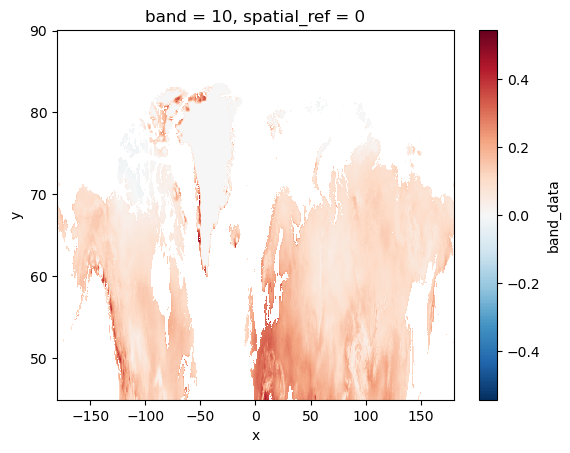

In [323]:
arclim_trends['band_data'].isel(band=9).plot();

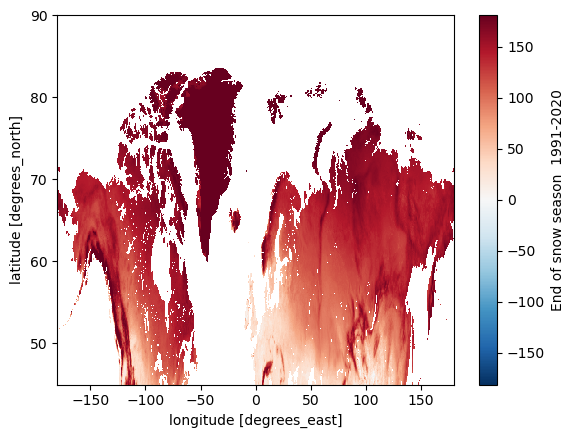

In [324]:
arclim['SSE'].plot();

In [325]:
snow_cover_mean = arclim['SSL']

In [326]:
ssl_interp = snow_cover_mean.interp(latitude=trends_noaa_all.coords['lat'], longitude=trends_noaa_all.coords['lon'], method='linear').squeeze()

In [327]:
ssl_interp

<xarray.DataArray 'SSL' (lat: 340, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    latitude   (lat) float32 55.03 55.08 55.12 55.17 ... 71.82 71.88 71.93 71.97
    longitude  (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.1 -150.0
  * lat        (lat) float32 55.03 55.08 55.12 55.17 ... 71.82 71.88 71.93 71.97
  * lon        (lon) float32 -168.0 -167.9 -167.9 ... -150.1 -150.1 -150.0
Attributes:
    long_name:   Snow season length 1991-2020
    short_name:  SSL

In [328]:
land_cover

<xarray.Dataset>
Dimensions:              (lat: 64800, lon: 129600)
Coordinates:
  * lat                  (lat) float32 90.0 90.0 89.99 ... -89.99 -90.0 -90.0
  * lon                  (lon) float32 -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    lccs_class           (lat, lon) float32 ...
    processed_flag       (lat, lon) float32 ...
    current_pixel_state  (lat, lon) float32 ...
    observation_count    (lat, lon) float32 ...
    change_count         (lat, lon) float32 ...
    crs                  int32 ...
Attributes: (12/38)
    title:                      ESA CCI Land Cover Map
    summary:                    This dataset contains the global ESA CCI land...
    type:                       ESACCI-LC-L4-LCCS-Map-300m-P1Y
    id:                         ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7
    project:                    Climate Change Initiative - European Space Ag...
    references:                 http://www.esa-landcover-cci.org/
    ...                         ...
    geospatial_lon_max:         180.0
    spatial_resolution:         300m
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  0.002778
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.002778

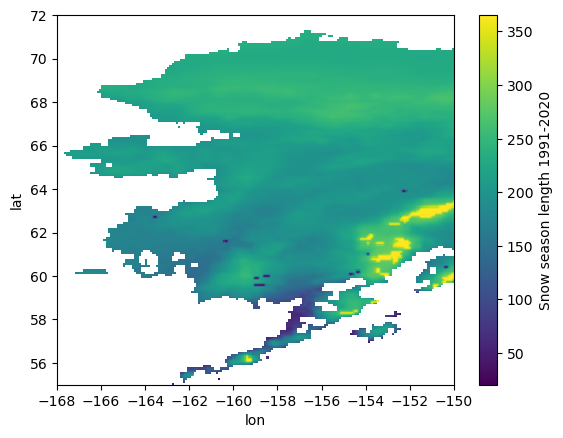

In [329]:
ssl_interp.plot();

In [330]:
trend_1d = trend['trends'].stack(points=("lat", "lon"))
snow_1d = ssl_interp.stack(points=("lat", "lon"))

mask = (
    ~np.isnan(trend_1d) &
    ~np.isnan(snow_1d)
)

trend_1d = trend_1d[mask]
snow_1d = snow_1d[mask]


In [331]:
x = snow_1d.to_numpy()
y = trend_1d.to_numpy()


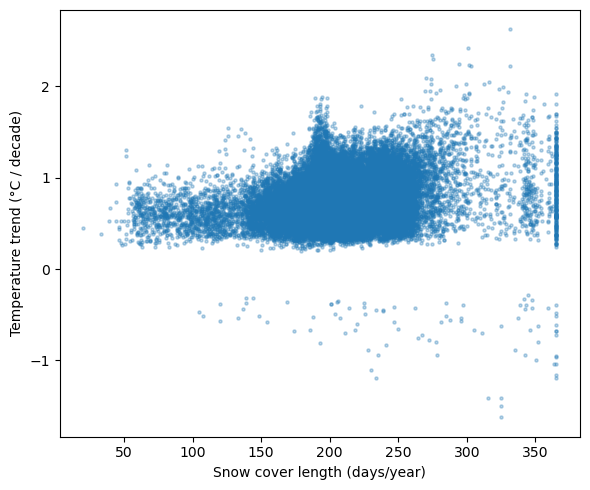

In [332]:
plt.figure(figsize=(6, 5))
plt.scatter(x, y, s=5, alpha=0.3)

plt.xlabel("Snow cover length (days/year)")
plt.ylabel("Temperature trend (°C / decade)")
plt.tight_layout()
plt.show()

In [333]:

bins = np.arange(0, 366, 30)
bin_labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]


In [334]:

df_bin = pd.DataFrame({
    "trend": y,
    "snow_len": x
})

df_bin["snow_bin"] = pd.cut(
    df_bin["snow_len"],
    bins=bins,
    labels=bin_labels,
    include_lowest=True
)
df_bin = df_bin.dropna(subset=["snow_bin"])


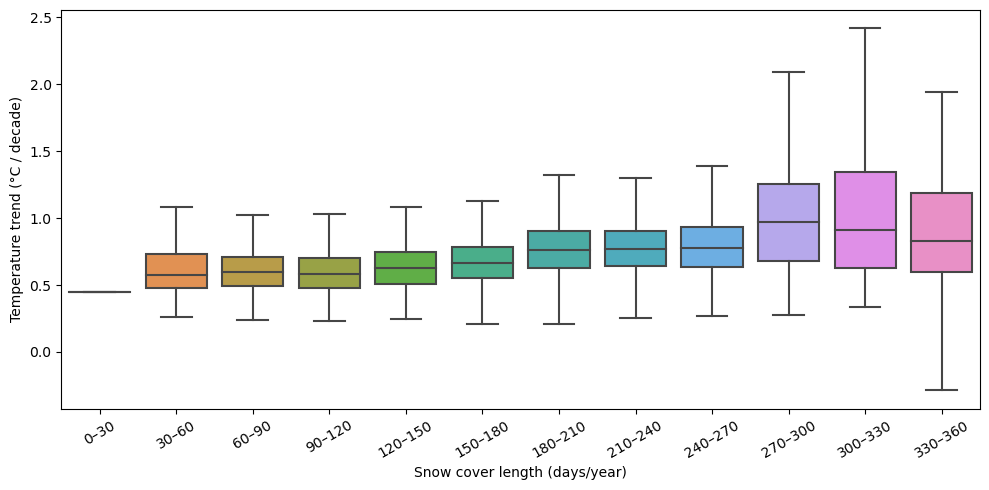

In [335]:
plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=df_bin,
    x="snow_bin",
    y="trend",
    showfliers=False
)

plt.xlabel("Snow cover length (days/year)")
plt.ylabel("Temperature trend (°C / decade)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
# trends per decade in relation to warming trends


In [336]:
snow_1d = ssl_interp.stack(points=("lat", "lon"))
lc_1d   = lc_interp['lccs_class'].stack(points=("lat", "lon"))

mask = (
    ~np.isnan(snow_1d) &
    ~np.isnan(lc_1d)
)

snow_1d = snow_1d[mask]
lc_1d   = lc_1d[mask]

In [337]:
import pandas as pd

df = pd.DataFrame({
    "snow_length": snow_1d.to_numpy(),
    "landcover": lc_1d.to_numpy().astype(int)
})

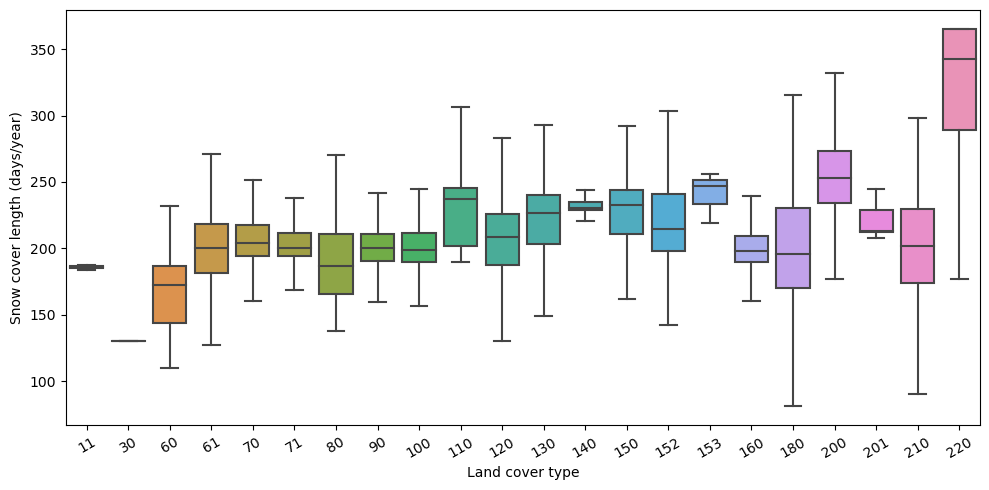

In [338]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=df,
    x="landcover",
    y="snow_length",
    showfliers=False
)

plt.xlabel("Land cover type")
plt.ylabel("Snow cover length (days/year)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
# just to see which classes have varrying snow cover durations!